In [1]:
import os
from keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.preprocessing import image
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Data augmentation with ImageDataGenerator

> Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better


In [2]:
BATCH_SIZE = 16 # batch size
NB_TRAIN_IMG = 224 # number of training images
NB_VALIDATION_IMG = 79 # number of test images
EPOCHS=5

In [3]:
train_datagen = image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input # use the preprocessing that is required for the base model!
)

# apply the same preprocessing for the test data but not the augmentation
test_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input) 

The generator functions can be used to directly load data from the hard drive. We need to organiza our training and test data in separate folders:

```
─ test
│   ├── apple
│   ├── banana
│   └── orange
└── train
    ├── apple
    ├── banana
    └── orange
```

In [4]:
# this returns an iterator that fetches (X, y) pairs in batches
# keras allready does the one-hot encoding for us

train_iter = train_datagen.flow_from_directory(
    '../data/train', target_size=(224,224), batch_size=BATCH_SIZE)
test_iter = test_datagen.flow_from_directory(
    '../data/test', target_size=(224,224), batch_size=BATCH_SIZE)

Found 227 images belonging to 3 classes.
Found 79 images belonging to 3 classes.


In [5]:
# to get the class names and codes use
train_iter.class_indices

{'apple': 0, 'banana': 1, 'orange': 2}

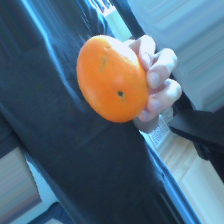

In [6]:
X = next(train_iter)[0]
image.array_to_img(X[4])

# Transfer Learning

## Transfer Learning via Feature Extraction

1. select a base model e.g. VGG16, MobileNet, ...
2. freeze all layers of the base model (set `layer.trainable=False`)
3. add one or several custom dense layer(s) ontop
4. train the model 

In [10]:
#decided to try the DenseNet121 as my base model

base_model = DenseNet121(
    include_top=False,
    input_shape=(224,224,3),
    pooling='avg' # average pooling transforms 4d tensor to 2d feature matrix similar to flatten
)

In [11]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [12]:
# freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# add custom layer on top of base model
model = Sequential()
model.add(base_model)
model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1024)              7037504   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               102500    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 7,140,307
Trainable params: 102,803
Non-trainable params: 7,037,504
_________________________________________________________________


In [14]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(
    optimizer='Adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [16]:
#added callbacks-earlyStopping in case the model does not improve over each Epoch.

callbacks = [
    EarlyStopping(monitor='val_loss',
                  patience=2,
                  verbose=0,
                  restore_best_weights=False,)
]


history = model.fit_generator(
        train_iter,
        steps_per_epoch= NB_TRAIN_IMG // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=test_iter,
        validation_steps=NB_VALIDATION_IMG // BATCH_SIZE,
        callbacks = callbacks)

Epoch 1/5
14/14 [==============================] - 76s 5s/step - loss: 0.3499 - accuracy: 0.8527 - val_loss: 0.7170 - val_accuracy: 0.8281
Epoch 2/5
14/14 [==============================] - 74s 5s/step - loss: 0.2879 - accuracy: 0.8839 - val_loss: 0.9755 - val_accuracy: 0.8730
Epoch 3/5
14/14 [==============================] - 72s 5s/step - loss: 0.3258 - accuracy: 0.8795 - val_loss: 0.5538 - val_accuracy: 0.7937
Epoch 4/5
14/14 [==============================] - 72s 5s/step - loss: 0.3276 - accuracy: 0.8616 - val_loss: 0.1007 - val_accuracy: 0.9365
Epoch 5/5
14/14 [==============================] - 74s 5s/step - loss: 0.2774 - accuracy: 0.8973 - val_loss: 0.1131 - val_accuracy: 0.9206


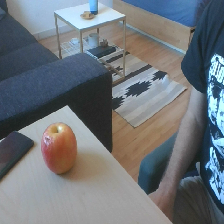

In [18]:
#image example
img = image.load_img('../data/train/apple/2020-04-13-16-12-26.png', 
                    target_size=(224, 224))
img

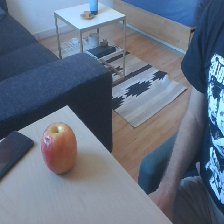

In [20]:
#processed image example
x = preprocess_input(image.img_to_array(img))
image.array_to_img(x)

In [21]:
#prediction
pred = model.predict(x.reshape(1, 224, 224, 3))
pred

array([[9.7386205e-01, 3.8377449e-04, 2.5754163e-02]], dtype=float32)

In [24]:
#next prediction
img = image.load_img('../data/train/banana/2020-04-13-16-12-34.png', 
                    target_size=(224, 224))
x = preprocess_input(image.img_to_array(img))
image.array_to_img(x)
pred = model.predict(x.reshape(1, 224, 224, 3))
pred

array([[0.00147923, 0.9941479 , 0.00437289]], dtype=float32)

In [25]:
#last prediciton
img = image.load_img('../data/train/orange/2020-04-13-16-12-40.png', 
                    target_size=(224, 224))
x = preprocess_input(image.img_to_array(img))
image.array_to_img(x)
pred = model.predict(x.reshape(1, 224, 224, 3))
pred

array([[1.2612608e-01, 3.4657915e-04, 8.7352735e-01]], dtype=float32)

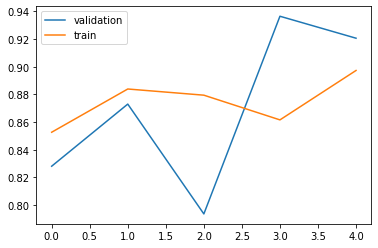

In [29]:
#couldn't get this to work
plt.plot(range(5), history.history['val_accuracy'], label='validation')
plt.plot(history.history['accuracy'], label='train')
plt.legend()

## Transfer Learning via Fine Tuning (optional additional step)

**only apply after performing the steps from above!**

5. unfreeze some of the top layers in the base model
6. further train the model

In [30]:
# unfreeze some of the top layers
for layer in base_model.layers[15:19]:
    layer.trainable=True
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1024)              7037504   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               102500    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 7,127,763
Trainable params: 102,803
Non-trainable params: 7,024,960
_________________________________________________________________


/home/samuelmcguire/anaconda3/envs/image_classifier/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [31]:
# continue model fitting, also use EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=0)
]

history = model.fit_generator(
        train_iter,
        steps_per_epoch= NB_TRAIN_IMG // BATCH_SIZE,
        epochs=5,
        validation_data=test_iter,
        validation_steps=NB_VALIDATION_IMG // BATCH_SIZE,
        callbacks=callbacks)

Epoch 1/5
14/14 [==============================] - 163s 12s/step - loss: 0.2607 - accuracy: 0.8795 - val_loss: 0.1621 - val_accuracy: 0.9062
Epoch 2/5
14/14 [==============================] - 78s 6s/step - loss: 0.1516 - accuracy: 0.9554 - val_loss: 0.1573 - val_accuracy: 0.8730
Epoch 3/5
14/14 [==============================] - 81s 6s/step - loss: 0.1067 - accuracy: 0.9732 - val_loss: 0.2908 - val_accuracy: 0.8571
Epoch 4/5
14/14 [==============================] - 89s 6s/step - loss: 0.1367 - accuracy: 0.9509 - val_loss: 0.2382 - val_accuracy: 0.9048


In [32]:
#some test predicitons
img = image.load_img('../data/train/apple/2020-04-13-16-12-18.png', 
                    target_size=(224, 224))
x = preprocess_input(image.img_to_array(img))
image.array_to_img(x)
pred = model.predict(x.reshape(1, 224, 224, 3))
pred

array([[9.5849544e-01, 5.8883984e-07, 4.1503977e-02]], dtype=float32)

In [33]:
img = image.load_img('../data/train/banana/2020-04-13-16-12-05.png', 
                    target_size=(224, 224))
x = preprocess_input(image.img_to_array(img))
image.array_to_img(x)
pred = model.predict(x.reshape(1, 224, 224, 3))
pred

array([[3.7567029e-04, 9.9088013e-01, 8.7441839e-03]], dtype=float32)

In [34]:
img = image.load_img('../data/train/orange/2020-04-13-16-12-11.png', 
                    target_size=(224, 224))
x = preprocess_input(image.img_to_array(img))
image.array_to_img(x)
pred = model.predict(x.reshape(1, 224, 224, 3))
pred

array([[3.9116497e-04, 5.4440545e-07, 9.9960822e-01]], dtype=float32)

In [35]:
#save model for use in realtime capture program
model.save('a_b_o_2905.h5')